# Calculating and plotting VOD

In [1]:
import gnssvod as gv
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.dates as mdates
from definitions import FIG, DATA, ROOT, get_repo_root, AUX, GROUND, TOWER

## gv.calc_vod()
The first step is to calculate VOD for different bands.

Note that this function will likely be modified in a next release. One problem is that the observations labels ('S1C','S1X', etc.) are not always associated to the same frequency depending on which constellation is observed. The labeling also changes according to the RINEX versions. In the future, frequency will need to be tracked along with SNR.

The calc_vod() function calculates VOD by first evaluating the SNR difference between the individual pairs of observations. The SNR from the clear-sky reference is subtracted from the SNR at the subcanopy station. The attenuation is corrected for the elevation of the satellite, yielding a VOD value.

In [2]:
# set which data files should be loaded

pattern = str(DATA / "gather" / "*.nc")
# define how to associate stations together. Always put reference station first.
pairings = {'MOz':('MOz1_Grnd','MOz1_Twr')}
# define if some observables with similar frequencies should be combined together. In the future, this should be replaced by the selection of frequency bands.
bands = {'VOD1':['S1','S1X','S1C'],'VOD7':['S7','S7X','S7C']}

vod = gv.calc_vod(pattern,pairings,bands)
vod = vod['MOz']
vod

VOD1  VOD7  Azimuth  Elevation
Epoch               SV                                     
2024-05-01 00:00:00 E03 -0.244643   NaN    157.4       62.3
                    E05 -0.392123   NaN     57.2       45.2
                    E08  0.122979   NaN   -160.6       19.5
                    E13 -0.000000   NaN    -55.3       13.1
                    E15 -1.163119   NaN    -29.7       62.4
...                           ...   ...      ...        ...
2024-05-01 23:59:45 R21 -0.876353   NaN    -33.3       26.6
                    S31       NaN   NaN      NaN        NaN
                    S33       NaN   NaN      NaN        NaN
                    S35       NaN   NaN      NaN        NaN
                    S58       NaN   NaN      NaN        NaN

[144781 rows x 4 columns]

## Hemispheric plot of VOD
Same as in the previous example, we will use the Hemi class to calculate and plot a gridded representation of VOD

In [3]:
# intialize hemispheric grid
hemi = gv.hemibuild(2)
# get patches for plotting later
patches = hemi.patches()
# classify vod into grid cells, drop azimuth and elevation afterwards as we don't need it anymore
vod = hemi.add_CellID(vod).drop(columns=['Azimuth','Elevation'])
# get average value per grid cell
vod_avg = vod.groupby(['CellID']).agg(['mean', 'std', 'count'])
# flatten the columns
vod_avg.columns = ["_".join(x) for x in vod_avg.columns.to_flat_index()]
vod_avg

,VOD1_mean,VOD1_std,VOD1_count,VOD7_mean,VOD7_std,VOD7_count
CellID,,,,,,
0,0.270523,0.134669,8,NaN,NaN,0
1,-0.168669,0.218998,6,NaN,NaN,0
2,0.010046,0.214244,16,NaN,NaN,0
4,0.429681,0.120154,9,NaN,NaN,0
5,-0.008082,0.404001,17,NaN,NaN,0
...,...,...,...,...,...,...
6419,-0.138023,0.039683,3,NaN,NaN,0
6421,NaN,NaN,0,NaN,NaN,0
6432,-0.122058,0.016830,5,NaN,NaN,0


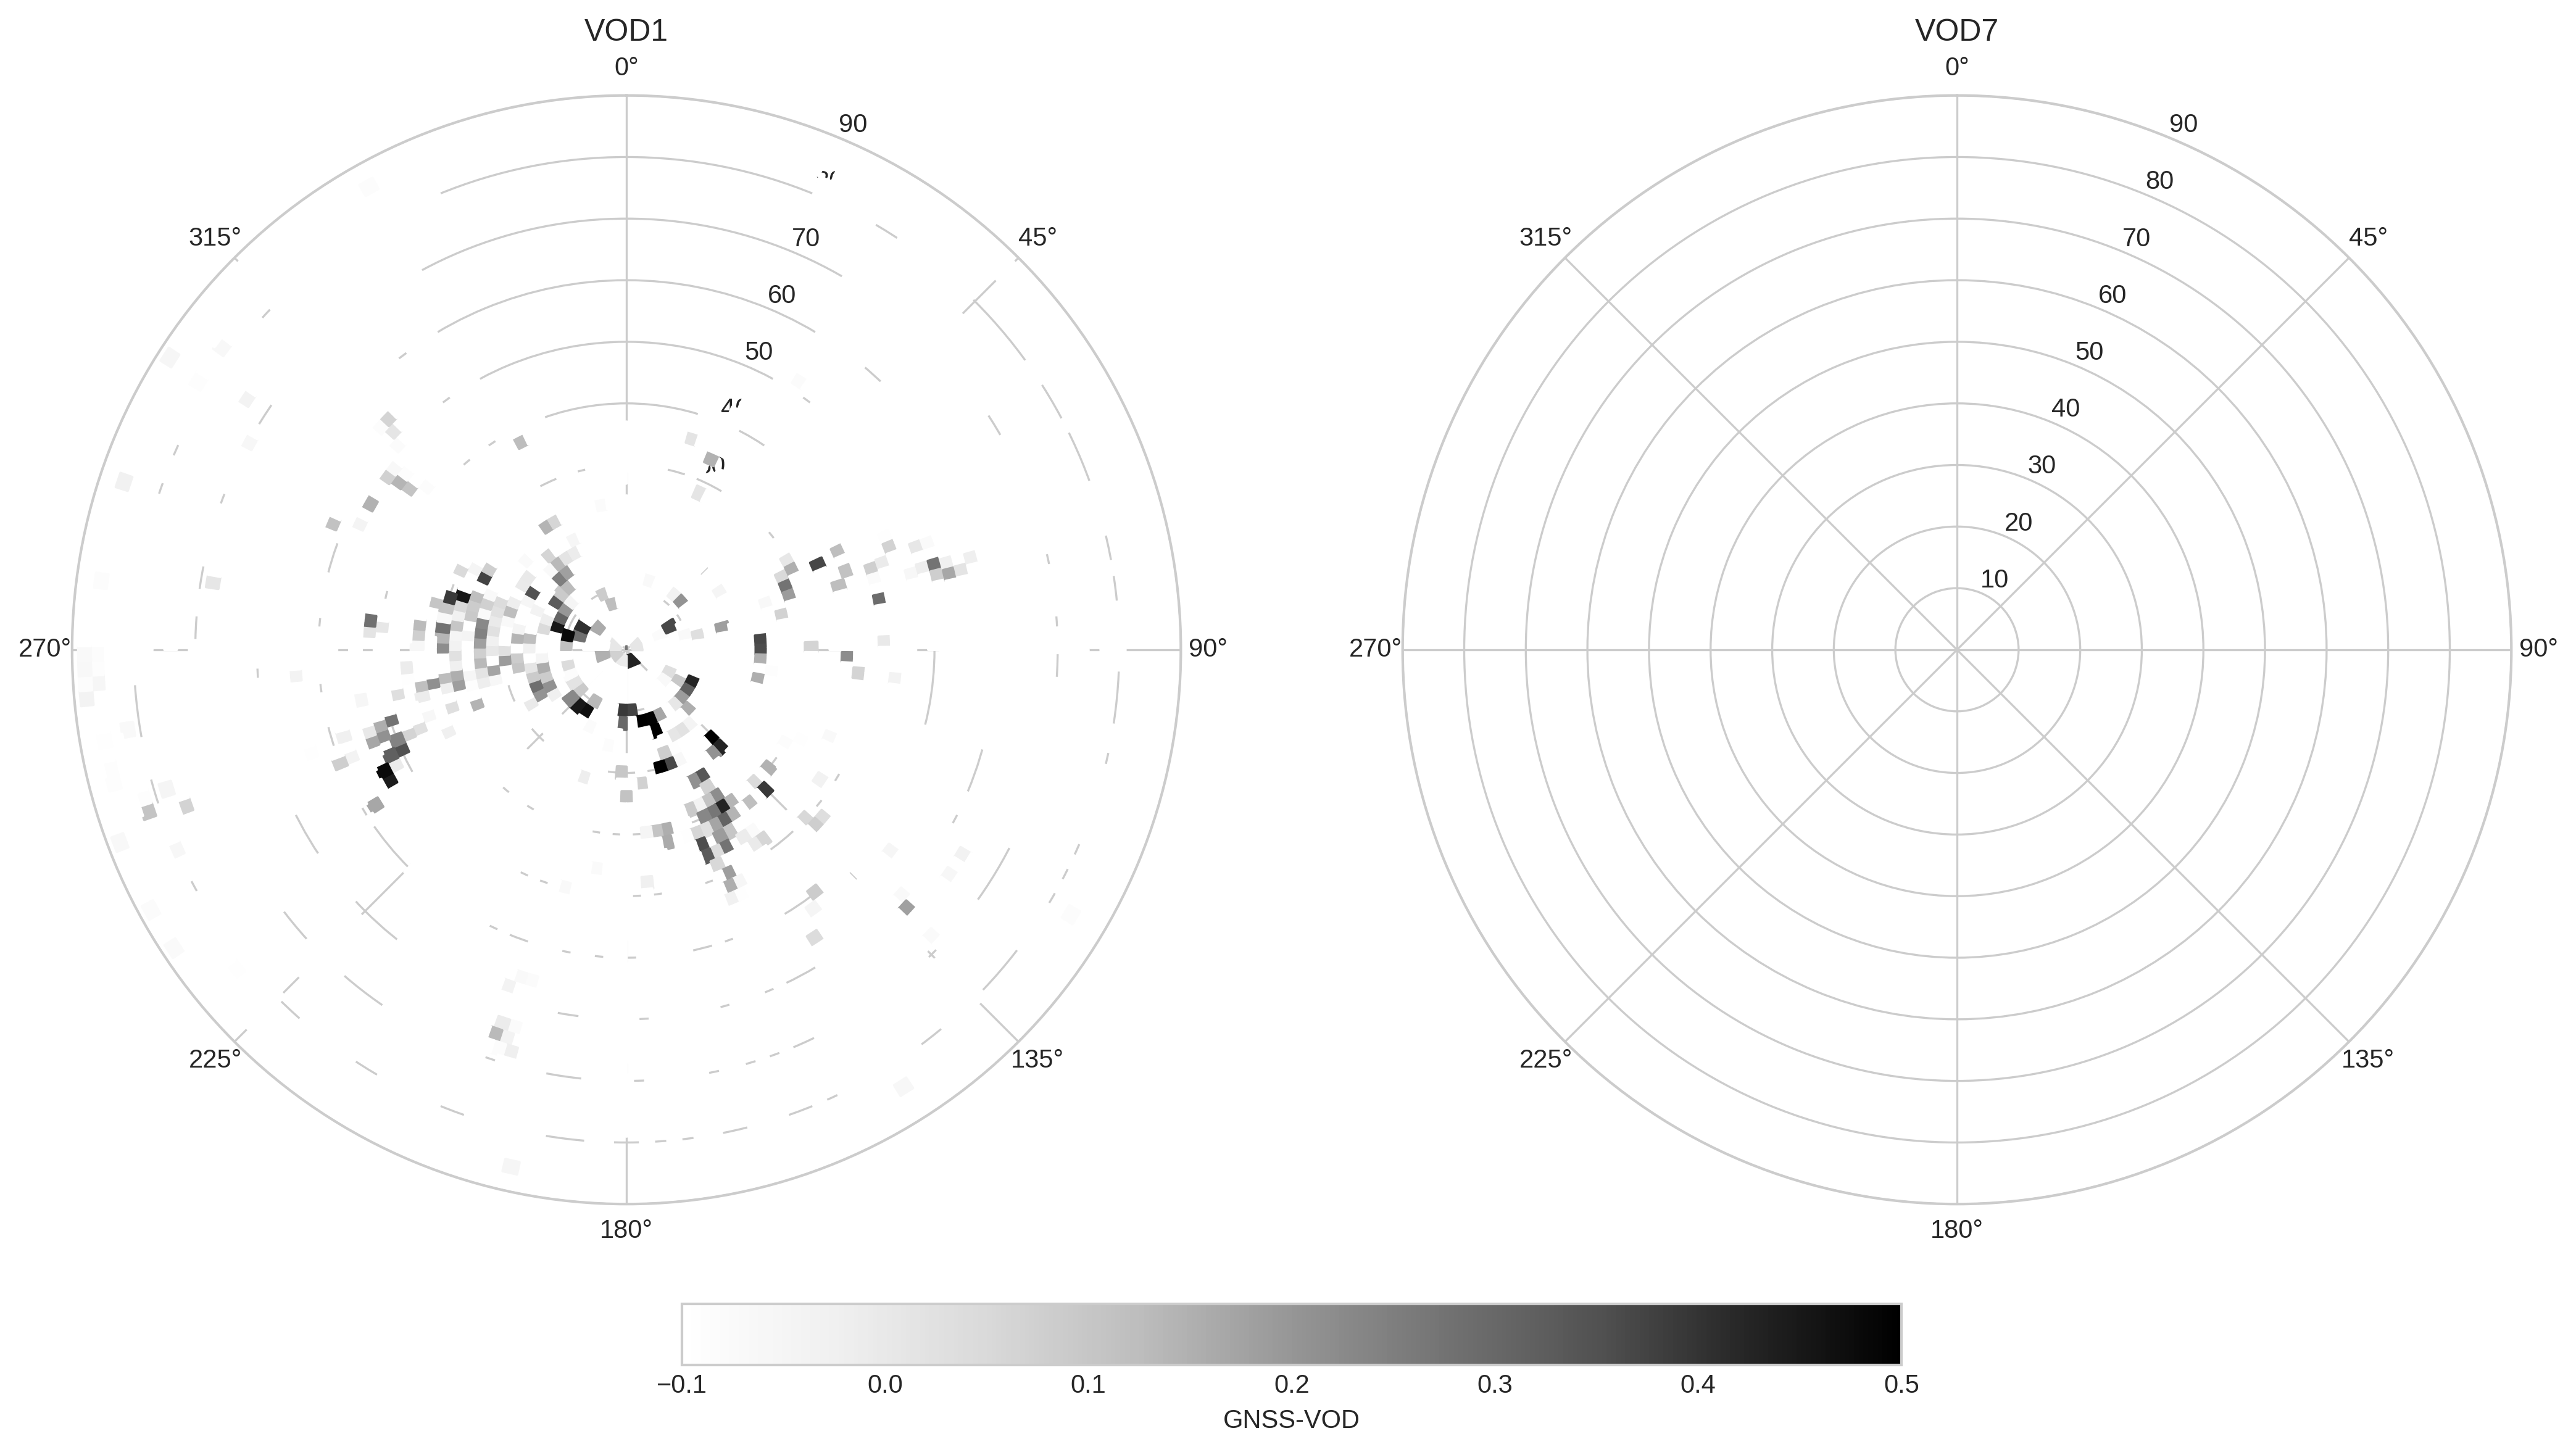

In [4]:
fig, ax = plt.subplots(1,2,figsize=(17,14),subplot_kw=dict(projection='polar'))

vod_names = ['VOD1','VOD7']
for i, iname in enumerate(vod_names):
    # associate the mean values to the patches, join inner will drop patches with no data, making plotting slightly faster
    ipatches = pd.concat([patches,vod_avg[f"{iname}_mean"]],join='inner',axis=1)
    # plotting with colored patches
    pc = PatchCollection(ipatches.Patches,array=ipatches[f"{iname}_mean"],edgecolor='face', linewidth=1)
    pc.set_clim([-0.1,0.5])
    ax[i].add_collection(pc)
    ax[i].set_rlim([0,90])
    ax[i].set_theta_zero_location("N")
    ax[i].set_theta_direction(-1)
    ax[i].set_title(iname)

plt.colorbar(pc, ax=ax, location='bottom', shrink=.5, pad=0.05, label='GNSS-VOD')

It can be a good idea to only plot the average if a minimum number of values were used to calculate an average. Sometimes results at the edges are only based on a few data points and are not very reliable.

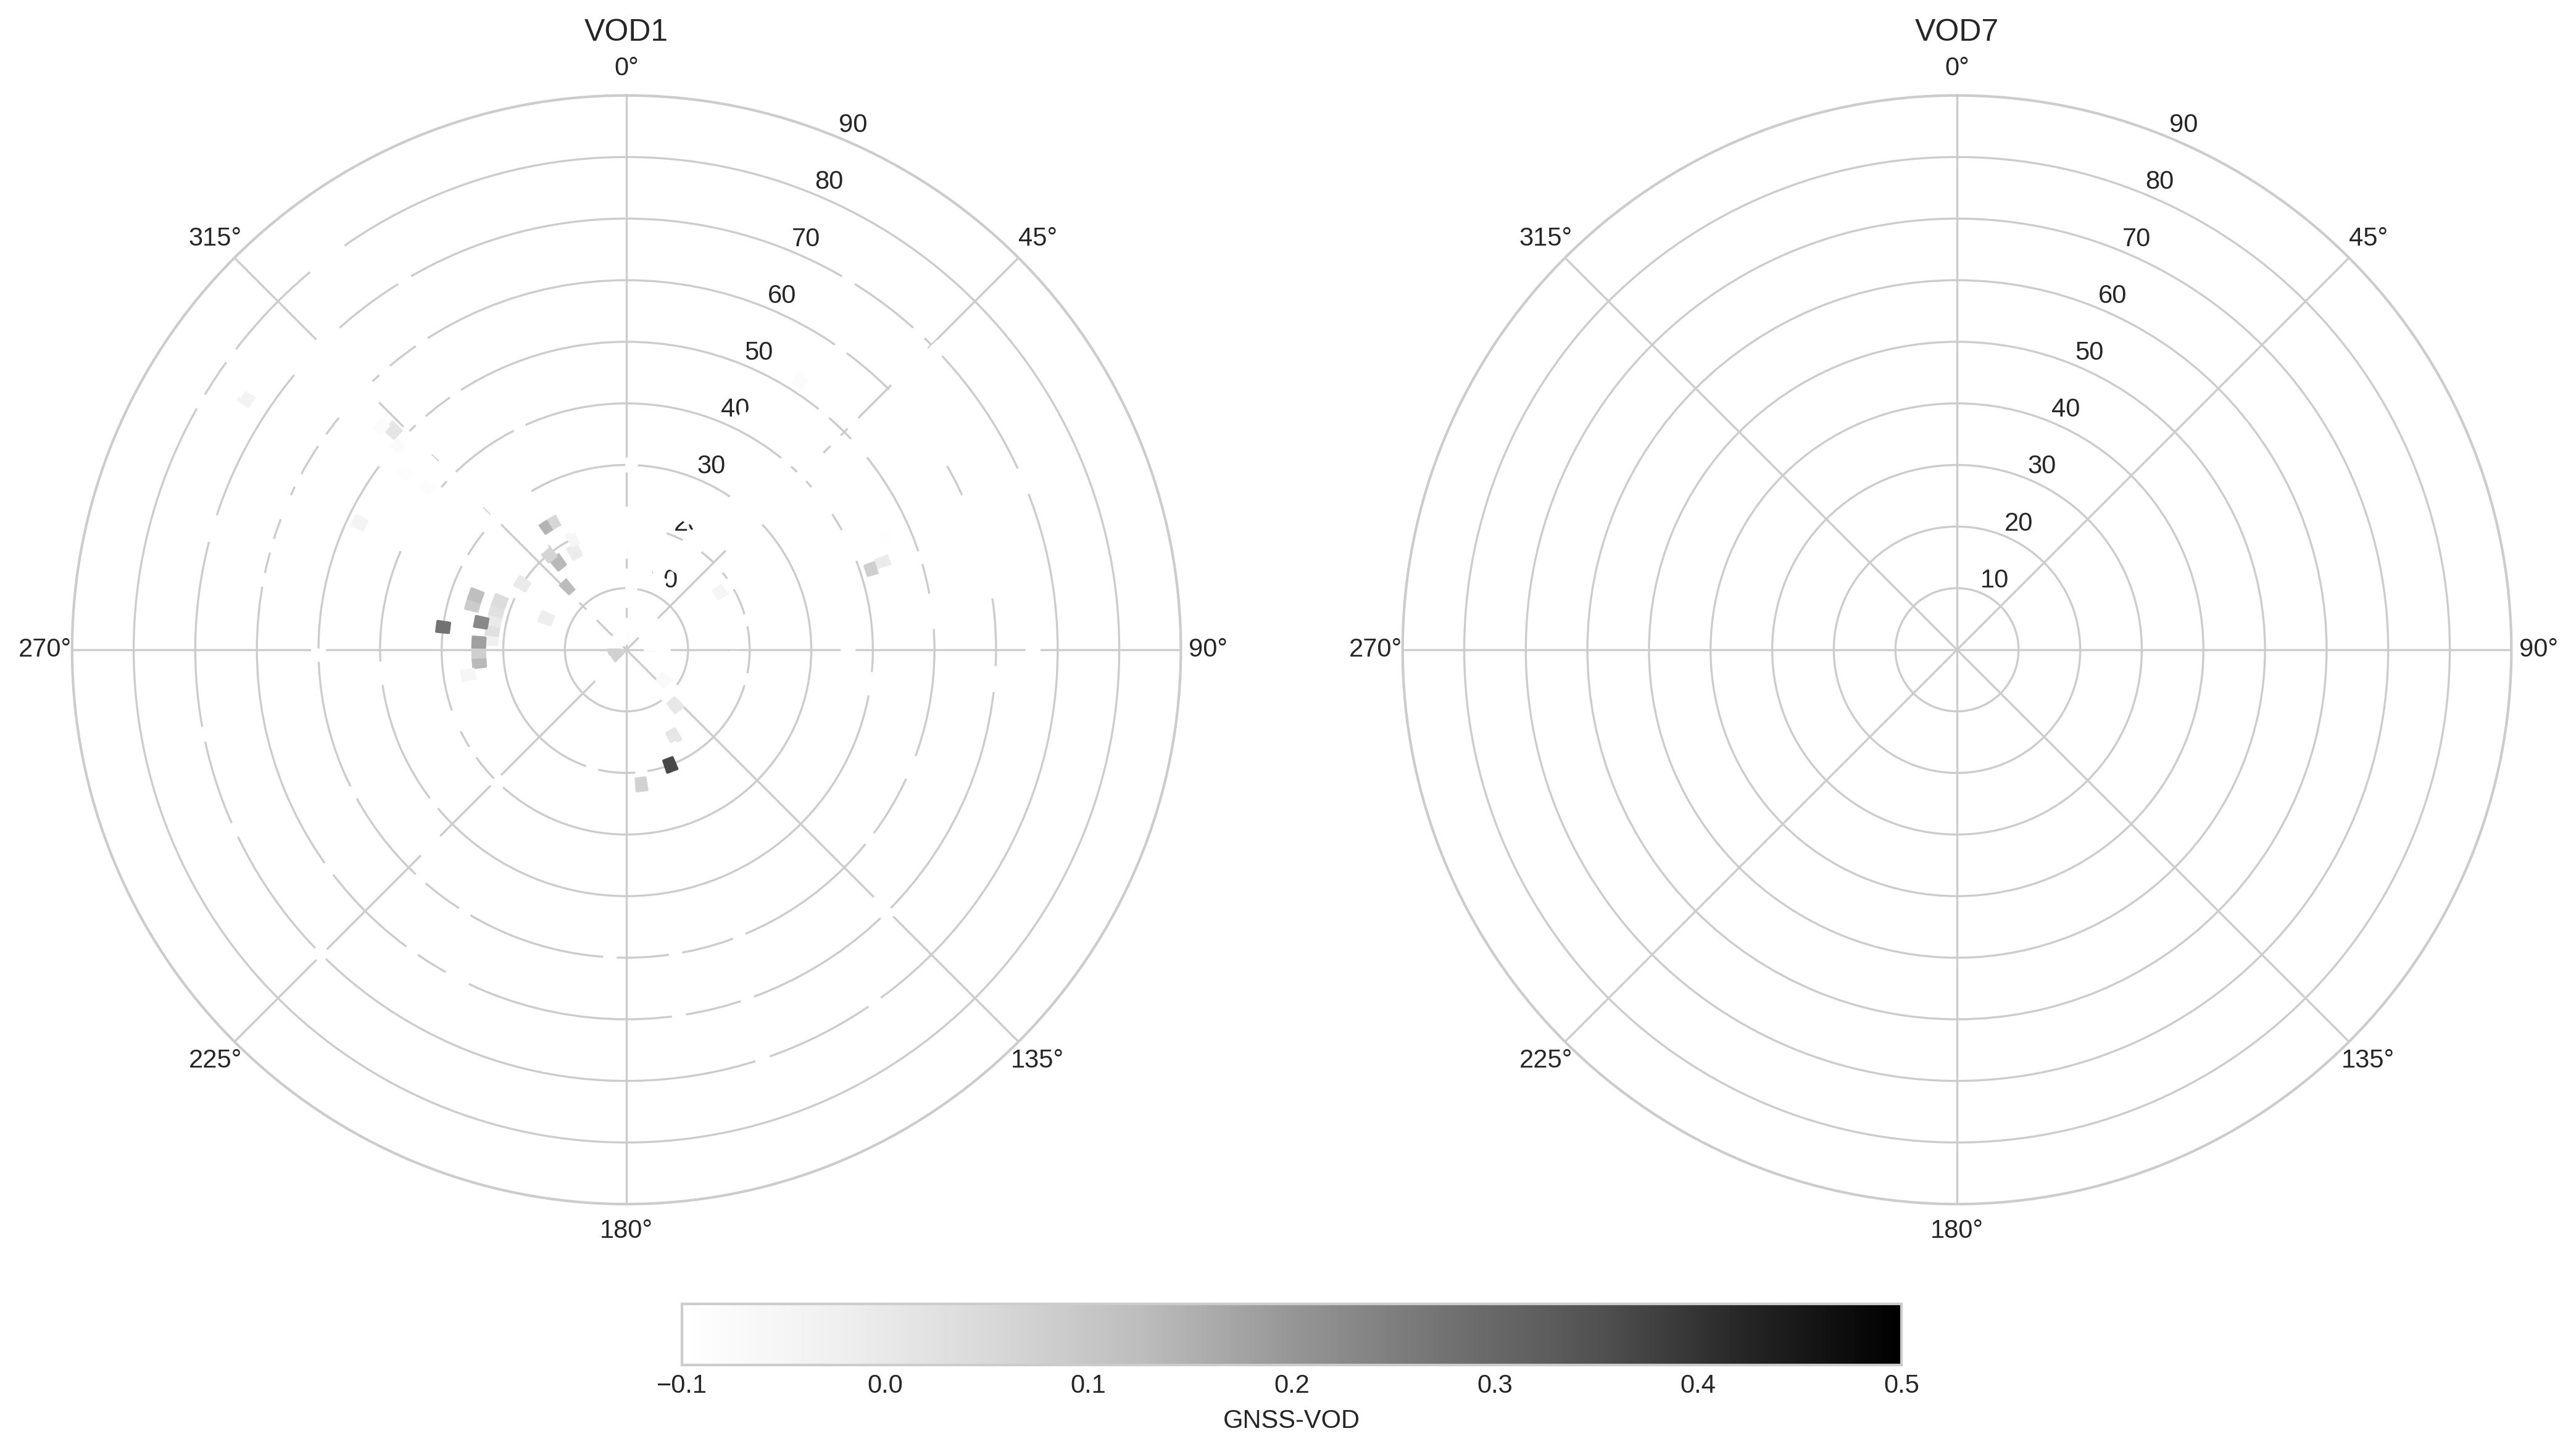

In [5]:
fig, ax = plt.subplots(1,2,figsize=(17,14),subplot_kw=dict(projection='polar'))

vod_names = ['VOD1','VOD7']
for i, iname in enumerate(vod_names):
    # associate the mean values to the patches, join inner will drop patches with no data, making plotting slightly faster
    ivod_data = vod_avg[f"{iname}_mean"].where(vod_avg[f"{iname}_count"]>40)
    ipatches = pd.concat([patches,ivod_data],join='inner',axis=1)
    # plotting with colored patches
    pc = PatchCollection(ipatches.Patches,array=ipatches[f"{iname}_mean"],edgecolor='face', linewidth=1)
    pc.set_clim([-0.1,0.5])
    ax[i].add_collection(pc)
    ax[i].set_rlim([0,90])
    ax[i].set_theta_zero_location("N")
    ax[i].set_theta_direction(-1)
    ax[i].set_title(iname)

plt.colorbar(pc, ax=ax, location='bottom', shrink=.5, pad=0.05, label='GNSS-VOD')

## Calculation of VOD time series
Because the tracks of the satellites are not random but tend to repeat every day, one has to be a bit careful when computing temporal averages of VOD. For instance, satellites of the GPS constellation repeat twice every sidereal day (1 sidereal day = 23h 56m 4s). Other constellations (below) have slightly more complex repeat times.

![](figures/rev_per_day.png)

Imagine what would happen if most GNSS satellites happen to repeatedly go over slightly denser areas of the canopy every day at around 3:30pm. We would tend to see a peak in VOD each day at that time. However, the average VOD of the forest is not actually increasing, the peak exists only because we happen to be measuring parts of the canopy that are on average slightly denser. Especially when looking at very small changes in VOD (for instance diurnal variability), these repeating orbits create spurious signals and obfuscate the real variability. Check __[Humphrey & Frankenberg 2023](https://bg.copernicus.org/articles/20/1789/2023/bg-20-1789-2023.html)__, Figure 7 to see how this affects time series. 

Processing a more accurate VOD time series involves three steps:
- Calculating a baseline (long-term mean) hemispheric VOD over a sufficiently long time period (which we just did)
- Calculate VOD anomalies by subtracting the baseline from each instantaneous VOD measurement
- Calculate a time series based on the VOD anomalies

### Calculating VOD anomalies
Here we merge back the VOD average to the original dataframe.

In [6]:
# merge statistics with the original VOD measurements
vod_anom = vod.join(vod_avg,on='CellID')
vod_anom

VOD1  VOD7  CellID  VOD1_mean  VOD1_std  \
Epoch               SV                                                 
2024-05-01 00:00:00 E03 -0.244643   NaN     762   0.090168  0.336478   
                    E05 -0.392123   NaN    1788  -0.894199  0.596301   
                    E08  0.122979   NaN    4329  -0.204700  0.269262   
                    E13 -0.000000   NaN    5050  -0.180669  0.205996   
                    E15 -1.163119   NaN     814  -0.848066  0.534133   
...                           ...   ...     ...        ...       ...   
2024-05-01 23:59:45 R04 -0.964347   NaN    3602  -0.893878  0.332166   
                    R05 -2.087358   NaN     122  -1.832063  0.704923   
                    R19 -0.974188   NaN    3659  -0.512518  0.435499   
                    R20 -1.218865   NaN     125  -0.500103  0.756741   
                    R21 -0.876353   NaN    3769  -0.716872  0.407004   

                         VOD1_count  VOD7_mean  VOD7_std  VOD7_count  
Epoch               SV                                                
2024-05-01 00:00:00 E03          28        NaN       NaN           0  
                    E05          46        NaN       NaN           0  
                    E08          22        NaN       NaN           0  
                    E13          67        NaN       NaN           0  
                    E15          49        NaN       NaN           0  
...                             ...        ...       ...         ...  
2024-05-01 23:59:45 R04          31        NaN       NaN           0  
                    R05          16        NaN       NaN           0  
                    R19           3        NaN       NaN           0  
                    R20          26        NaN       NaN           0  
                    R21          30        NaN       NaN           0  

[120872 rows x 9 columns]

Anomalies are simply obtained with:

In [7]:
vod_anom['VOD1_anom'] = vod_anom['VOD1']-vod_anom['VOD1_mean']
vod_anom['VOD7_anom'] = vod_anom['VOD7']-vod_anom['VOD7_mean']

### Calculating the anomaly time series
Here we calculate an hourly average

In [9]:
vod_ts = vod_anom.groupby(pd.Grouper(freq='1h', level='Epoch')).mean()
vod_ts

,VOD1,VOD7,CellID,VOD1_mean,VOD1_std,VOD1_count,VOD7_mean,VOD7_std,VOD7_count,VOD1_anom,VOD7_anom
Epoch,,,,,,,,,,,
2024-05-01 00:00:00,-0.688644,NaN,2425.785895,-0.678759,0.417566,38.819046,NaN,NaN,0.0,0.002818,NaN
2024-05-01 01:00:00,-0.636361,NaN,2347.129047,-0.633471,0.424928,39.757194,NaN,NaN,0.0,-0.006306,NaN
2024-05-01 02:00:00,-0.578983,NaN,2665.244550,-0.576530,0.374790,34.298727,NaN,NaN,0.0,0.004355,NaN
2024-05-01 03:00:00,-0.611073,NaN,3118.851220,-0.591712,0.360337,38.569981,NaN,NaN,0.0,-0.017081,NaN
2024-05-01 04:00:00,-0.696222,NaN,3094.521661,-0.655466,0.386726,33.979964,NaN,NaN,0.0,-0.022296,NaN
2024-05-01 05:00:00,-0.653141,NaN,2825.203025,-0.655973,0.398619,37.994029,NaN,NaN,0.0,0.010892,NaN
2024-05-01 06:00:00,-0.643246,NaN,3021.917840,-0.640654,0.379854,34.605786,NaN,NaN,0.0,0.003476,NaN
2024-05-01 07:00:00,-0.663302,NaN,2704.634486,-0.648115,0.397020,33.715537,NaN,NaN,0.0,-0.000321,NaN
2024-05-01 08:00:00,-0.637285,NaN,2523.418105,-0.629608,0.396845,38.760849,NaN,NaN,0.0,0.003293,NaN


We should not forget to add the mean VOD back, otherwise the anomaly time series will be centred around zero

In [10]:
vod_ts['VOD1_anom'] = vod_ts['VOD1_anom']+vod_ts['VOD1'].mean()
vod_ts['VOD7_anom'] = vod_ts['VOD7_anom']+vod_ts['VOD7'].mean()

Now let's compare our time series, with and without subtracting the baseline.

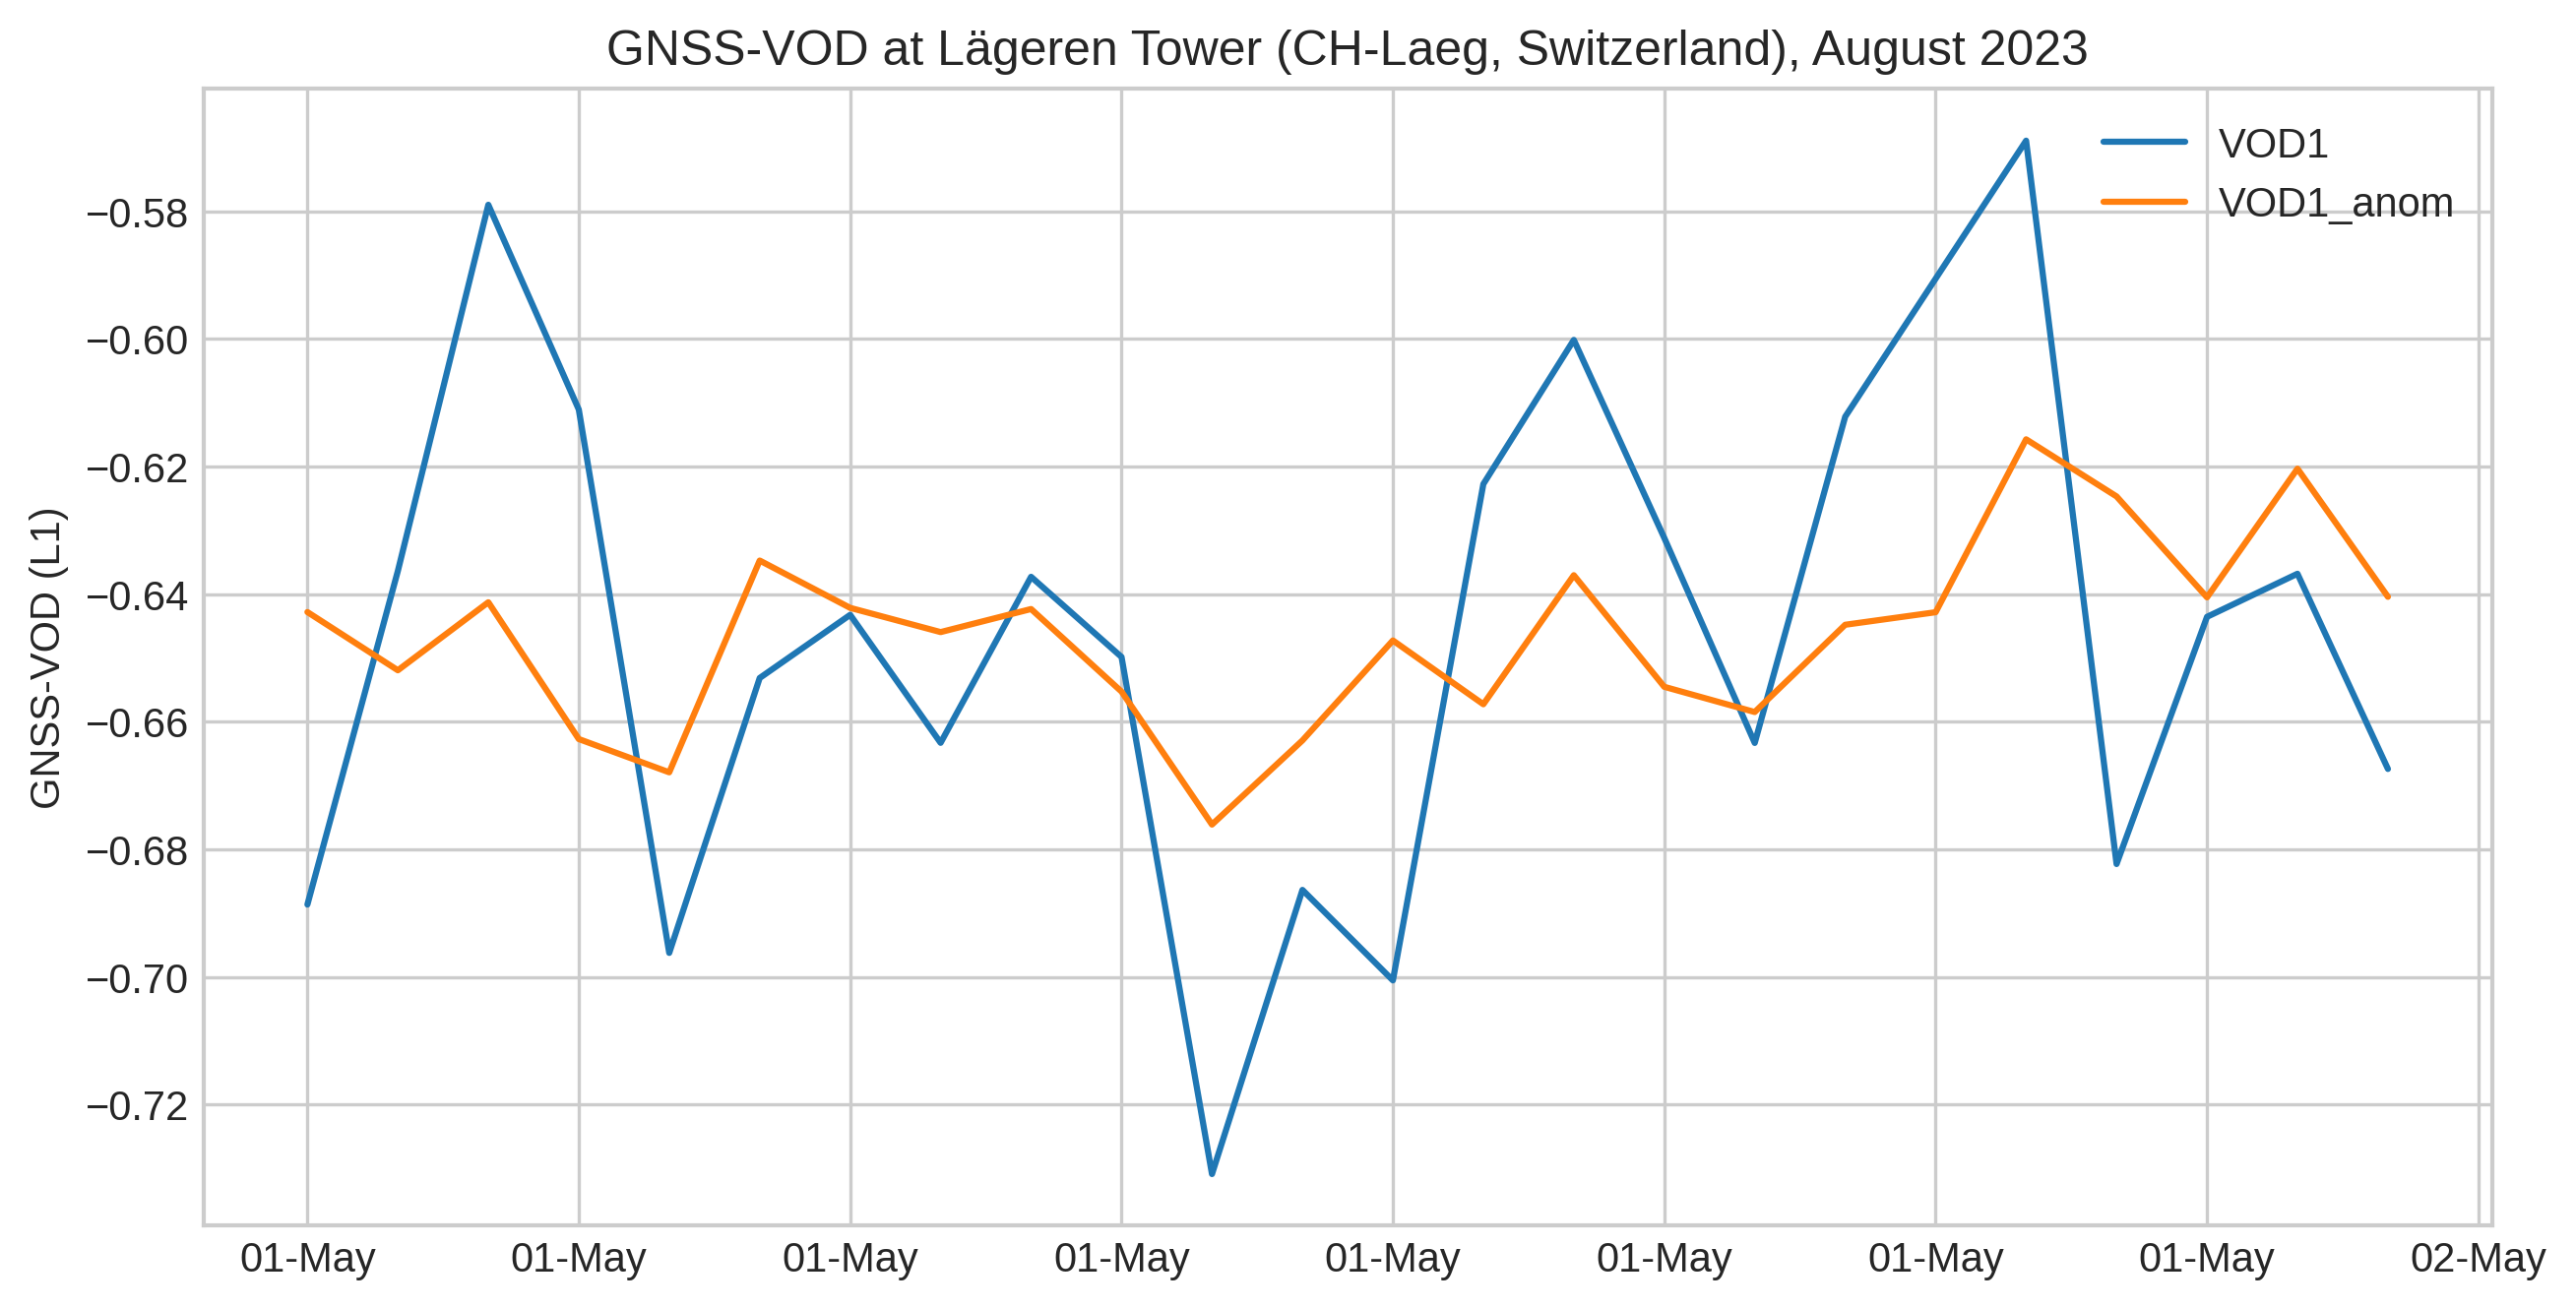

In [11]:
vod_names = ['VOD1','VOD1_anom']

fig, ax = plt.subplots(1,figsize=(10,5))
for i, iname in enumerate(vod_names): 
    # plot each measurement and color by signal to noise ratio
    hs = ax.plot(vod_ts.index.get_level_values('Epoch'),vod_ts[iname],label=iname)
    
myFmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GNSS-VOD (L1)')
ax.legend()
plt.title('GNSS-VOD at Lägeren Tower (CH-Laeg, Switzerland), August 2023')
plt.savefig('figures/illustration_vod.png',facecolor='white', transparent=False,bbox_inches='tight')

We clearly see how subtracting the gridded hemispheric average before calculating the time series has substantially reduced the noise in our VOD time series. Here we see short spikes usually corresponding to rain events and water interception by the canopy. A very small diurnal cycle is somewhat visible on August 3 to 6, with dehydration during day and rehydration overnight.

### Longer time series

In principle, when calculating a time series over several months, the baseline should be regularly updated. One option could be to go for a "moving" baseline, with a window of a few weeks.

In the next release, there should be some functions to do exactly that with a batch logic (i.e. automatically).